## 4.3 Policy Iteration

Jack manages two locations for a nationwide car rental company. Each day, some number of customers arrive at each location to rent cars. If Jack has a car available, he rents it out and is credited 10 dollars by the national company. If he is out of cars at that location, then the business is lost. Cars become available for renting the day after they are returned. To help ensure that cars are avialable when they are needed, Jack can move them between the two locations overnight, at a cost of 2 dollars per car moved. We assume that the number of cars requested and returned at each location are Poisson random variables, meaning that the probability that the number if $n$ is $\frac {\lambda^n} {n!} e^{-\lambda}$, where $\lambda$ is the expected number. Suppose $\lambda$ is 3 and 4 for rental requests at the first and second locations and 3 and 2 for returns. To simplify the problem slightly, we assume that there can be no more than 20 cars at each location (any additional cars are returned to the nationwide company, and thus disappear from the problem) and a maximum of five cars can be moved from one location to the other in one night. We take the discount rate to be $\gamma = 0.9$ and formulate this as a continuing finie MDP, where the time steps are days, the state is the number of cars at each location at the end of the day, and the actions are the net numbers of cars moved between the two locations overnight.

### Exercise 4.7:

Write a program for policy iteration and re-solve Jac's car rental problem with the following changes. One of Jack's employees at the first location rides a bus home each night and lives near the second location. She is happy to shuttle one car to the second location for free. Each additional car still costs 2.00 dollars, as do all cars moved in the other direction. In addition, Jack has limited parking space at each location. If more than 10 cars are kept overnight at a location (after any moving of cars), then an additional cost of 4 dollars must be incurred to use a second parking lot (independent of how many cars are kept there). These sorts of nonlinearities and arbitrary dynamics often occur in real problems and cannot easily be handled by optimization methods other than dynamic programming. To check your rogram, first replicate the results given for the original problem.

In [5]:
import math
import matplotlib.pyplot as plt
import numpy as np

## The Poisson Distribution

First, we will define a pmf for the Poisson distribution. This will be useful for defining other things throughout the problem.

$$
f(k;\lambda) = \frac {\lambda^ke^{-\lambda}} {k!}
$$



In [13]:

def factorial(n):
    r = 1

    for i in range(1, n + 1):
        r *= i

    return r


def poisson_pmf(lambd, k):
    """
    Compute the poisson probability of k events happening within the time interval lambda.
    """
    return pow(lambd, k) * math.exp(-lambd) / factorial(k)


The probability that an event happens 10 or less times is 0.9997262831771443


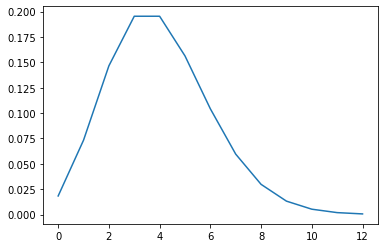

In [17]:
poisson_samples = [poisson_pmf(4.0, i) for i in range(0, 13)]

plt.plot(poisson_samples)

print("The probability that an event happens 10 or less times is %s" % (np.sum(poisson_samples)))


Note that above, we compute the Poisson Distribution (with $\lambda = 4$) from k = 0 to 15. The cumalitive probability of an event happening at most 15 times with our given lambda is 99.9%. Because the Poisson distribution is defined up to Infinity, we need a reasonable cut-off point to estimate the probability distributions that we are using. For that reason, we will cut our Poisson calculations at 15. To make sure that probabilities still add up to 1, we will redistribute our distribute by setting a denominator to be the total probability of k <= 15. In addition, because we know that we want the Poisson distributions for $\lambda$ 2, 3, and 4, we will pre-compute those values here.

In [19]:
# Because Poisson is defined up to Infinity, but the vast majority of
# probability density is clustered at lower values, we estimate the
# distribution by computing up to 15 and dividing by the total density to ensure
# that all our probabilities add to 1.

poisson_2 = np.array([poisson_pmf(2.0, i) for i in range(0, 16)])
poisson_3 = np.array([poisson_pmf(3.0, i) for i in range(0, 16)])
poisson_4 = np.array([poisson_pmf(4.0, i) for i in range(0, 16)])

poisson_2 /= np.sum(poisson_2)
poisson_3 /= np.sum(poisson_3)
poisson_4 /= np.sum(poisson_4)

## The Original Problem

Let's start by solving the original problem, and verify that we get the same solution described in the book.

First, we need to correctly model the problem in terms of the value functions and probability distributions.

- The possible states are the number of cars at each location, which is no more than 20. That means a total of 21 * 21 = 441 states.
- There are at most 6 possible actions from each state (moving up to 5 cars from one location to another). Note that we ignore strictly dominated actions, such as moving 3 cars from location A to location B and 3 cars from location B to location A, which is strictly worse than not moving any cars at all.
- The reward per day is the amount earned from rentals minus the cost of moving cars from the night before.

We need to know the full probabilty distribution $p(s', r | s, a)$. So for each state-action pair, we need the probability of each state-reward pair.
- There are 441 states, each containing at most 6 actions, so there is an upper limit of 441 * 11 = 4851 state-action pairs.
- For each state-action pair, we need the probability of any possible target state, reward pair.
- This number will start to get large, so we will define a function that, given a state-action pair, will compute a sequence of probability, next state, reward triples.



In [21]:
MAX_CARS_PER_LOCATION = 20
COST_PER_CAR_MOVED = 2

def probs(state, action):
    """
    Given a state-action pair, return a sequence of probability, next state, and reward triples.

    State is a tuple containing the the number of cars at the 2 locations.

    Action is a scalar indicating the number of cars to move from A to B. If
    the action is a negative scalar, that is equivalent to the cars moved from
    B to A.
    """
    cars_a, cars_b = state

    assert(abs(action) <= 6)
    assert(action < 0 or cars_a >= action)
    assert(action > 0 or cars_b >= action)

    total_reward = abs(action) * COST_PER_CAR_MOVED

    # Start by moving cars overnight.
    if action > 0:
        cars_a -= action
        cars_b = min(MAX_CARS_PER_LOCATION, cars_b + action)
    else:
        cars_b += action
        cars_a = min(MAX_CARS_PER_LOCATION, cars_a - action)

    # TODO: HERE I AM! 

